# Using PyBERT as a Library

This Jupyter notebook provides an example of using the functionality of the _PyBERT_ Python package, not as a stand alone GUI application, but rather as a library, importing into a higher level Python script.

Original author: David Banas <capn.freako@gmail.com>  
Original date:   June 28, 2021

Copyright &copy; 2021 David Banas, Inc.; all rights reserved World wide.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Global-Defines" data-toc-modified-id="Global-Defines-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global Defines</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#PyBERT-IBIS-AMI-Link-Simulation" data-toc-modified-id="PyBERT-IBIS-AMI-Link-Simulation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PyBERT IBIS-AMI Link Simulation</a></span><ul class="toc-item"><li><span><a href="#IBIS-AMI-Link-Diagram-and-Nomenclature" data-toc-modified-id="IBIS-AMI-Link-Diagram-and-Nomenclature-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>IBIS-AMI Link Diagram and Nomenclature</a></span></li><li><span><a href="#PyBERT-Object" data-toc-modified-id="PyBERT-Object-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>PyBERT Object</a></span></li><li><span><a href="#Notes" data-toc-modified-id="Notes-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Notes</a></span></li><li><span><a href="#Interconnect-Frequency-Response-&amp;-Characteristic-Impedance" data-toc-modified-id="Interconnect-Frequency-Response-&amp;-Characteristic-Impedance-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Interconnect Frequency Response &amp; Characteristic Impedance</a></span></li><li><span><a href="#Interconnect-S-parameters" data-toc-modified-id="Interconnect-S-parameters-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Interconnect S-parameters</a></span></li><li><span><a href="#Interconnect-Z-parameters" data-toc-modified-id="Interconnect-Z-parameters-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Interconnect Z-parameters</a></span></li><li><span><a href="#Complete-Channel-Frequency-Response" data-toc-modified-id="Complete-Channel-Frequency-Response-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Complete Channel Frequency Response</a></span></li></ul></li><li><span><a href="#Channel-Step-Response" data-toc-modified-id="Channel-Step-Response-5"><span class="toc-item-num">5&nbsp;&nbsp;</span><em>Channel</em> Step Response</a></span></li><li><span><a href="#Channel-Eye-Diagram" data-toc-modified-id="Channel-Eye-Diagram-6"><span class="toc-item-num">6&nbsp;&nbsp;</span><em>Channel</em> Eye Diagram</a></span><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Notes</a></span></li></ul></li><li><span><a href="#Tx-Deemphasis" data-toc-modified-id="Tx-Deemphasis-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Tx Deemphasis</a></span><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Notes</a></span></li></ul></li><li><span><a href="#Rx-CTLE" data-toc-modified-id="Rx-CTLE-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Rx CTLE</a></span><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Notes</a></span></li></ul></li><li><span><a href="#Combined-Tx/Rx-Equalization" data-toc-modified-id="Combined-Tx/Rx-Equalization-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Combined Tx/Rx Equalization</a></span><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Notes</a></span></li></ul></li><li><span><a href="#DFE" data-toc-modified-id="DFE-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>DFE</a></span><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Notes</a></span></li></ul></li><li><span><a href="#Jitter-Decomposition-&amp;-Bathtub-Curve-Plotting" data-toc-modified-id="Jitter-Decomposition-&amp;-Bathtub-Curve-Plotting-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Jitter Decomposition &amp; Bathtub Curve Plotting</a></span></li><li><span><a href="#Final-Touches" data-toc-modified-id="Final-Touches-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Final Touches</a></span><ul class="toc-item"><li><span><a href="#Random-Noise" data-toc-modified-id="Random-Noise-12.1"><span class="toc-item-num">12.1&nbsp;&nbsp;</span>Random Noise</a></span></li><li><span><a href="#CDR-Induced-Jitter" data-toc-modified-id="CDR-Induced-Jitter-12.2"><span class="toc-item-num">12.2&nbsp;&nbsp;</span>CDR Induced Jitter</a></span></li></ul></li></ul></div>

## Introduction

In the typical use case, [PyBERT](https://github.com/capn-freako/PyBERT/wiki) is run as a stand alone GUI application.
However, it is also possible to draw from the _PyBERT_ package, as a _library_, importing only certain needed features into a larger _Python_ script.
This [Jupyter](https://jupyter.org/) notebook provides an example of doing just that.

Furthermore, this example shows how to import _PyBERT_ functionality into a higher level _Python_ script, when [IBIS-AMI models](https://www.eetimes.com/ami-models-what-why-and-how/#) are being used, in place of PyBERT's native Tx/Rx models.

We'll take as our design goal PyBERT's default: attempting to move a 10 Gbps symbol stream through 1 meter of 28 gauge unshielded twisted pair (UTP) cabling.

## Global Defines

If you get lucky, you might get away w/ only editing this section.

In [1]:
TX_IBIS_FILE = "../../ibisami/example/example_tx.ibs"
RX_IBIS_FILE = "../../ibisami/example/example_rx.ibs"


## Imports

Here, we import everything we'll need.
(I'm not sure why, but these notebooks tend to work more smoothly if you import everything first, before executing any other Python code.)


In [28]:
%matplotlib inline

import sys
import pprint

print(f"Python executable: {sys.executable}")
print(f"Python exec_prefix: {sys.exec_prefix}")
print(f"Python prefix: {sys.prefix}")
print("Python import search path:")
pprint.pp(sys.path)

import matplotlib.pyplot as plt
import numpy             as np
import scipy             as sp
import scipy.signal      as sig
import skrf              as rf

import pybert            as pb
import pyibisami         as pyami

from pybert.pybert       import PyBERT
from pybert.pybert_cntrl import my_run_simulation
from pybert.pybert_util  import calc_eye, find_crossings, calc_jitter

from pyibisami.ami_model import AMIModel, AMIModelInitializer

print(f"PyBERT version: {pb.__version__}")
print(f"\tat: {pb.__file__}")

print(f"PyAMI version: {pyami.__version__}")
print(f"\tat: {pyami.__file__}")

print(f"NumPy version: {np.__version__}")
print(f"\tat: {np.__file__}")

print(f"SciPy version: {sp.__version__}")
print(f"\tat: {sp.__file__}")

print(f"SciKit-RF version: {rf.__version__}")
print(f"\tat: {rf.__file__}")

plt.rcParams['figure.figsize'] = [12, 8]

Python executable: /Users/dbanas/opt/anaconda3/envs/pybert/bin/python
Python exec_prefix: /Users/dbanas/opt/anaconda3/envs/pybert
Python prefix: /Users/dbanas/opt/anaconda3/envs/pybert
Python import search path:
['/Users/dbanas/Documents/Projects/PyBERT/misc',
 '/Users/dbanas/opt/anaconda3/envs/pybert/lib/python38.zip',
 '/Users/dbanas/opt/anaconda3/envs/pybert/lib/python3.8',
 '/Users/dbanas/opt/anaconda3/envs/pybert/lib/python3.8/lib-dynload',
 '',
 '/Users/dbanas/opt/anaconda3/envs/pybert/lib/python3.8/site-packages',
 '/Users/dbanas/opt/anaconda3/envs/pybert/lib/python3.8/site-packages/IPython/extensions',
 '/Users/dbanas/.ipython']
PyBERT version: 3.5.2
	at: /Users/dbanas/opt/anaconda3/envs/pybert/lib/python3.8/site-packages/pybert/__init__.py
PyAMI version: 3.5.1
	at: /Users/dbanas/opt/anaconda3/envs/pybert/lib/python3.8/site-packages/pyibisami/__init__.py
NumPy version: 1.21.2
	at: /Users/dbanas/opt/anaconda3/envs/pybert/lib/python3.8/site-packages/numpy/__init__.py
SciPy versio

## PyBERT IBIS-AMI Link Simulation

In this section we conduct our first IBIS-AMI link simulation using PyBERT.


### IBIS-AMI Link Diagram and Nomenclature

The IBIS-AMI simulation community uses some very specific nomenclature, to describe different parts of a serial communication link.
And correct usage of this nomenclature is necessary, in order to avoid confusion.
The diagram below illustrates how a serial communication link is conceptualized by an IBIS-AMI modeler and provides the correct nomenclature.

![IBIS-AMI Link Diagram & Nomenclature](IBIS-AMI_Link_Diagram.png)


### PyBERT Object

Here, we instantiate and configure our _PyBERT_ object and run a trial simulation of its default channel.

**Note:** You may need to dismiss some GUI dialog alerts.


In [3]:
# Instantiate a PyBERT object and change any defaults as required.
myPyBERT = PyBERT(run_simulation=False,  # Need to adjust some properties first.
                  gui=False)             # Don't run stand-alone; we're in a notebook.
# myPyBERT.debug = True  # Uncomment to debug.

# Instantiate/verify the IBIS-AMI files.
myPyBERT.tx_ibis_file = TX_IBIS_FILE  # Changing the `tx_ibis_file` parameter
assert (myPyBERT.tx_ibis_valid)       # triggers a reloading of the IBIS model.
assert (myPyBERT.tx_dll_file)         # We're expecting to be given IBIS-AMI models,
assert (myPyBERT.tx_ami_file)         # which must include *.AMI and *.DLL files.
assert (myPyBERT.tx_ami_valid)
assert (myPyBERT.tx_dll_valid)

myPyBERT.rx_ibis_file = RX_IBIS_FILE
assert (myPyBERT.rx_ibis_valid)
assert (myPyBERT.rx_dll_file)
assert (myPyBERT.rx_ami_file)
assert (myPyBERT.rx_ami_valid)
assert (myPyBERT.rx_dll_valid)

# Tell PyBERT to use the I/O IBIS models, instead of its native models.
myPyBERT.tx_use_ibis = True
myPyBERT.rx_use_ibis = True

# Run the simulation and print out the resultant log for sanity checking.
my_run_simulation(myPyBERT,
                  initial_run=True,    # PyBERT does some "housekeeping" the first time through, which shouldn't be repeated.
                  update_plots=False)  # We'll do our own plotting, here in this notebook.
print(myPyBERT.console_log)

# Grab some resultant data needed below.
ui         = myPyBERT.ui                         # unit interval
nspb       = myPyBERT.nspb                       # samples per bit
t          = myPyBERT.t                          # simulation time vector
Ts         = t[1]                                # simulation sample interval
eye_bits   = myPyBERT.eye_bits                   # number of UIs to use for eye plotting.
ch_s       = myPyBERT.chnl_s                     # channel step response
Zref       = myPyBERT.Rs                         # Reference (i.e. - port) impedance of generated networks.
f_10MHz_ix = np.where(myPyBERT.f >= 10e6)[0][0]  # 10 MHz index into the PyBERT frequency vector
# We use 10 MHz as a proxy for "d.c." below.

PyBERT Console Log


[2022-01-03 07:44:55.573920]: PyBERT: Started.

[2022-01-03 07:44:55.573954]: PyBERT: System: Darwin 18.7.0

[2022-01-03 07:44:55.573965]: PyBERT: Python Version: 3.8.12

[2022-01-03 07:44:55.573970]: PyBERT: PyBERT Version: 3.5.2

[2022-01-03 07:44:55.573975]: PyBERT: PyAMI Version: 3.5.1

[2022-01-03 07:44:55.573982]: PyBERT: GUI Toolkit: qt

[2022-01-03 07:44:55.573988]: PyBERT: Kiva Backend: qpainter

[2022-01-03 07:44:57.348403]: PyBERT: Parsing Tx IBIS file, '../../ibisami/example/example_tx.ibs'...

[2022-01-03 07:44:57.391634]: PyBERT: Result:
Success!

[2022-01-03 07:44:57.397286]: PyBERT: Parsing Tx AMI file, '../../ibisami/example/example_tx.ami'...

[2022-01-03 07:44:57.402964]: PyBERT: Success.

[2022-01-03 07:44:57.403457]: PyBERT: Parsing Rx IBIS file, '../../ibisami/example/example_rx.ibs'...

[2022-01-03 07:44:57.444024]: PyBERT: Result:
Success!

[2022-01-03 07:44:57.465018]: PyBERT: Parsing Rx AMI file, '../../ibisami/example/example_rx.ami'...



### Notes

1. Channel delay: {{f"{(myPyBERT.chnl_dly * 1e9):5.2f} ns"}}

1. Tx driver output impedance: {{f"{myPyBERT.Rs:5.0f} Ohms"}}

1. Tx driver parasitic capacitance: {{f"{myPyBERT.Cs*1e12:5.1f} pF"}}

1. Rx input resistance: {{f"{myPyBERT.RL:5.0f} Ohms"}}

1. Rx input capacitance: {{f"{myPyBERT.Cp*1e12:5.1f} pF"}}


### Interconnect Frequency Response & Characteristic Impedance

Here we plot the calculated raw _frequency response_ and _characteristic impedance_ for the interconnect, for sanity checking.

**Notes:**

1. The frequency response shown here would be equivalent to the $S_{21}$ of a 2-port network representing just the interconnect and with port impedances precisely matched to the interconnect characteristic impedance, at _every_ frequency.
That is why no ripples are observed.

1. Note that this interconnect has a raw bandwidth below 1 GHz.

    **Question:** Would you expect it to support our target Baud rate (10 GBaud)?

1. Our native PyBERT interconnect has a characteristic impedance slightly larger than the reference: $100 \Omega$.

Zref = 100 Ohms


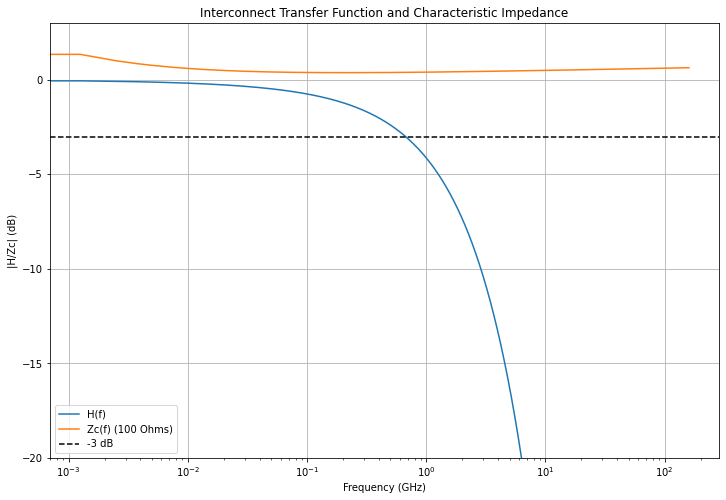

In [4]:
print(f"Zref = {Zref:3.0f} Ohms")
plt.semilogx(myPyBERT.f/1e9, 20*np.log10(abs(myPyBERT.H)[:len(myPyBERT.f)]),       label="H(f)")
plt.semilogx(myPyBERT.f/1e9, 20*np.log10(abs(myPyBERT.Zc)[:len(myPyBERT.f)]/Zref), label="Zc(f) (100 Ohms)")
plt.title("Interconnect Transfer Function and Characteristic Impedance")
plt.xlabel("Frequency (GHz)")
plt.ylabel("|H/Zc| (dB)")
plt.axis(ymax=3, ymin=-20)
plt.axhline(-3, color='k', linestyle='dashed', label='-3 dB')
plt.legend()
plt.grid()
plt.show()


### Interconnect S-parameters

Here we generate and plot the calculated 2-port network for the _interconnect_, for sanity checking.

**Notes:**

1. This does _not_ include the actual termination at the Rx input.  
(Here, the line is assumed to be terminated into the reference impedance.)

1. The reference impedance is set equal to the Tx output driver _differential_ impedance
and assumed real.

1. Because the network is calculated, as opposed to measured, it is perfectly symmetrical.
Therefore, S11 perfectly overlaps S22 and likewise for S21/S12.
That is why only two traces seem to be present.


Zref = 100 Ohms


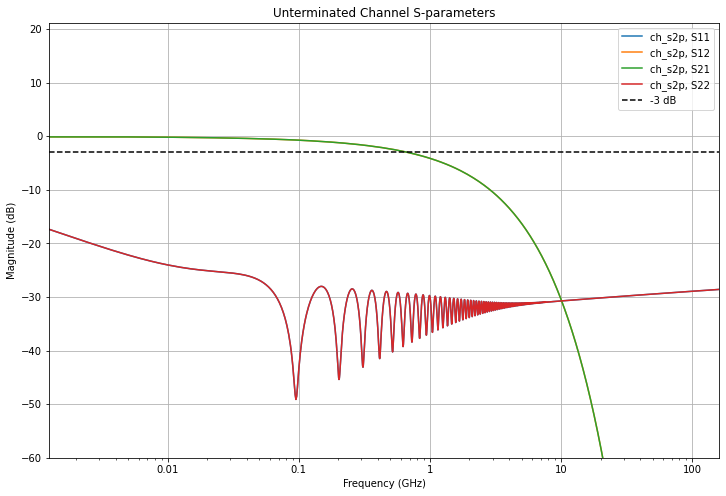

In [5]:
print(f"Zref = {Zref:3.0f} Ohms")
myPyBERT.ch_s2p.plot_s_db(title="Unterminated Channel S-parameters", logx=True)
plt.axis(ymin=-60)
plt.axhline(-3, color='k', linestyle='dashed', label='-3 dB')
plt.legend()
plt.grid()
plt.show()


### Interconnect Z-parameters

Here we plot the calculated 2-port Z-parameters of the interconnect, for sanity checking.
The plot characteristics can be explained as follows:

1. The resonance peaks are due to multiple full positive reflections at both ends of the line.

    - Z-parameters of a 2-port network are taken with a current source driving one port and the other port open circuited. And both of those terminations exhibit infinite impedance.

    - The position of the first resonance peak is correct, as per:

        $$
        \begin{eqnarray}
        f =& \frac{1}{\tau_{round trip}} \\
        =& \frac{1}{10 ns} \\
        =& 100 MHz
        \end{eqnarray}
        $$

1. The decay in the amplitude of the resonance peaks is due to increasing loss through the interconnect at high frequency, which lessens the number of significant reflections contributing to the superposition.

1. The trend toward infinite impedance at very low frequency is real and correct and due to the lack of any d.c. shunt path in the interconnect itself.  

1. The asymptotic decay of Z11/Z22 to approximately 100 $\Omega$ is due the high frequency loss through the interconnect being so great that not even the first reflection makes it back to the driven port with any significant amplitude, and all that is "seen" by the entering wave is the characteristic impedance of the interconnect.

1. The asymptotic decay to zero of Z21/Z12 is for the same reason: no appreciable energy is making it to the far end of the interconnect, at those high frequencies.


Zref = 100 Ohms


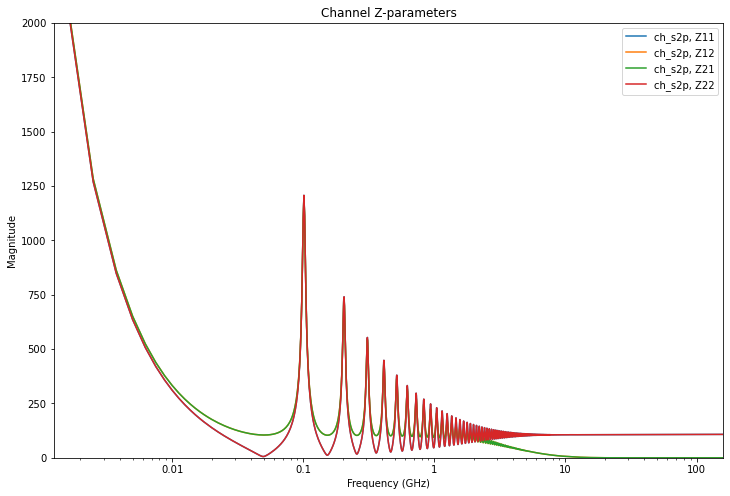

In [6]:
print(f"Zref = {Zref:3.0f} Ohms")
myPyBERT.ch_s2p.plot_z_mag(title="Channel Z-parameters", logx=True)
plt.axis(ymin=0, ymax=2e3)
plt.show()


### Complete Channel Frequency Response

Here we plot the frequency response of the _complete_ channel, including the _real_ Tx and Rx terminations (including their parasitic capacitance), for sanity checking.

**Notes:**

1. The ripples are due to multiple reflections caused by the imperfect Tx and Rx terminations.

1. The inclusion of the parasitic capacitances of the Tx and Rx terminations has _not_ appreciably shifted the bandwidth of this interconnect.


Zref = 100 Ohms


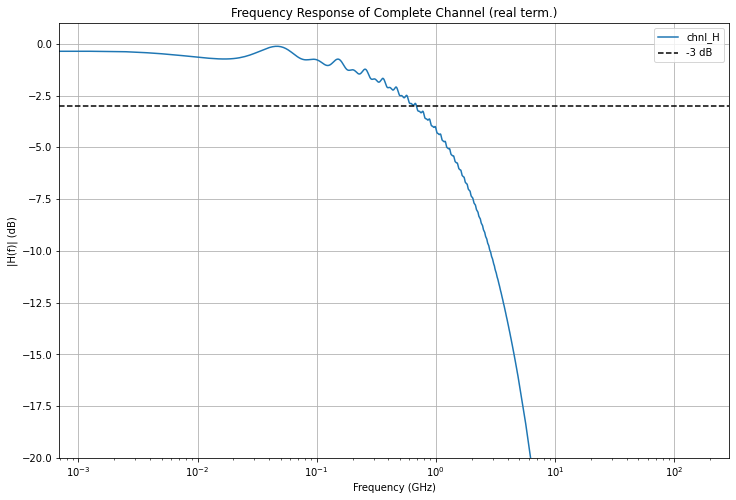

In [7]:
print(f"Zref = {Zref:3.0f} Ohms")
plt.semilogx(myPyBERT.f/1e9, 20*np.log10(abs(myPyBERT.chnl_H)[:len(myPyBERT.f)]), label="chnl_H")
plt.title("Frequency Response of Complete Channel (real term.)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("|H(f)| (dB)")
plt.axhline(-3, color='k', linestyle='dashed', label='-3 dB')
plt.axis(ymax=1, ymin=-20)
plt.grid()
plt.legend()
plt.show()


## _Channel_ Step Response

Here we plot the _channel_ step response corresponding to the simulation just run.

**Notes:**

1. The _Channel_ step response includes everything through and including the Rx analog termination, but no equalization.

1. Don't be alarmed that the position of the edge in the step response doesn't agree with the reported channel delay, above. PyBERT "trims" the step response for convenience/efficiency.


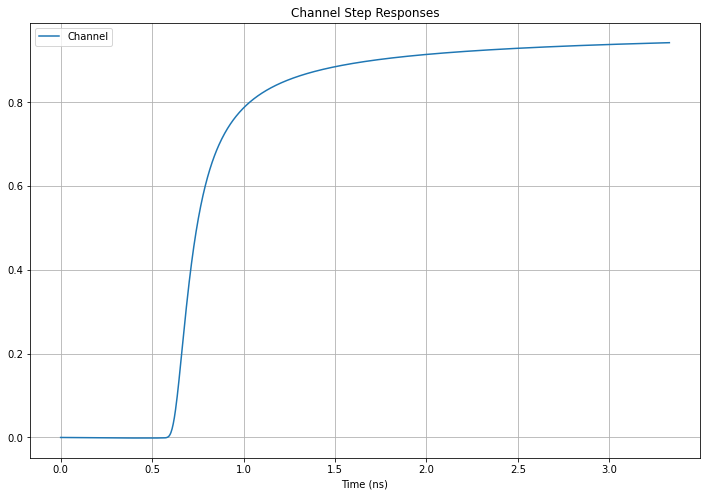

In [8]:
plt.plot (t[:len(ch_s)]*1e9, ch_s[:len(t)], label="Channel")
plt.title("Channel Step Responses")
plt.xlabel("Time (ns)")
plt.legend()
plt.grid()
plt.show()

## _Channel_ Eye Diagram

Let's take a look at the "eye" diagram for the channel alone.
That will give us some idea of whether or not we need to add any equalization.


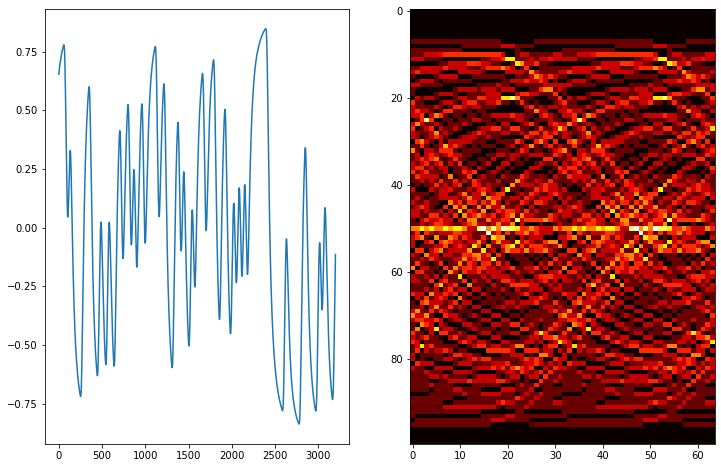

In [9]:
def plotsig(sig):
    """Plot last 100 unit intervals, as well as the 'eye' diagram, of a signal.
    """
    ys    = sig[-eye_bits*nspb:]
    y_max = np.max(ys) * 1.1
    img   = calc_eye(ui, nspb, 100, ys, y_max)
    plt.subplot(121)
    plt.plot(sig[-100*nspb:])
    plt.subplot(122)
    plt.hot()
    plt.imshow(img, aspect="auto")
    plt.show()

plotsig(myPyBERT.ctle_out)  # In the PyBERT simulation engine, `ctle_out` is the slicer input.


### Notes

1. The eye is completely closed.
(This shouldn't come as a surprise, given that the bandwidth of our interconnect is < 1 GHz and, yet, we're attempting to push a 10 GBaud symbol stream through it.)


## Tx Deemphasis

The eye above is completely closed.
Here we investigate the effect of adding Tx deemphasis on the system eye.

**Note:** If you changed the Tx IBIS file name, above, then you'll probably get an error like this, the first time you run this cell:

```
ValueError: Failed parameter tree search looking for: <ParamName>; available keys: dict_keys(['tx_tap_nm2', 'tx_tap_np1', 'tx_tap_units', 'tx_tap_nm1'])
```

Just swap in one of the listed available keys, in lines 2/3, and you should be good to go.


In [10]:
# myPyBERT._tx_cfg.configure_traits()  # Use the GUI configurator, for now.
myPyBERT._tx_cfg.set_param_val(["Model_Specific","tx_tap_np1"], 3)  # Valid range: 1-10.
myPyBERT._tx_cfg.set_param_val(["Model_Specific","tx_tap_nm1"], 5)  # Bypass the GUI config.
# print(myPyBERT._tx_cfg.fetch_param_val(["Model_Specific","tx_tap_nm1"]))
myPyBERT.tx_use_ami     = True
# myPyBERT.tx_use_getwave = True
my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
print(myPyBERT.console_log)

ui   = myPyBERT.ui           # unit interval
nspb = myPyBERT.nspb         # samples per bit
t    = myPyBERT.t            # simulation time vector
Ts   = t[1]                  # simulation time interval
eye_bits = myPyBERT.eye_bits # number of UIs to use for eye plotting.

PyBERT Console Log


[2022-01-03 07:44:55.573920]: PyBERT: Started.

[2022-01-03 07:44:55.573954]: PyBERT: System: Darwin 18.7.0

[2022-01-03 07:44:55.573965]: PyBERT: Python Version: 3.8.12

[2022-01-03 07:44:55.573970]: PyBERT: PyBERT Version: 3.5.2

[2022-01-03 07:44:55.573975]: PyBERT: PyAMI Version: 3.5.1

[2022-01-03 07:44:55.573982]: PyBERT: GUI Toolkit: qt

[2022-01-03 07:44:55.573988]: PyBERT: Kiva Backend: qpainter

[2022-01-03 07:44:57.348403]: PyBERT: Parsing Tx IBIS file, '../../ibisami/example/example_tx.ibs'...

[2022-01-03 07:44:57.391634]: PyBERT: Result:
Success!

[2022-01-03 07:44:57.397286]: PyBERT: Parsing Tx AMI file, '../../ibisami/example/example_tx.ami'...

[2022-01-03 07:44:57.402964]: PyBERT: Success.

[2022-01-03 07:44:57.403457]: PyBERT: Parsing Rx IBIS file, '../../ibisami/example/example_rx.ibs'...

[2022-01-03 07:44:57.444024]: PyBERT: Result:
Success!

[2022-01-03 07:44:57.465018]: PyBERT: Parsing Rx AMI file, '../../ibisami/example/example_rx.ami'...



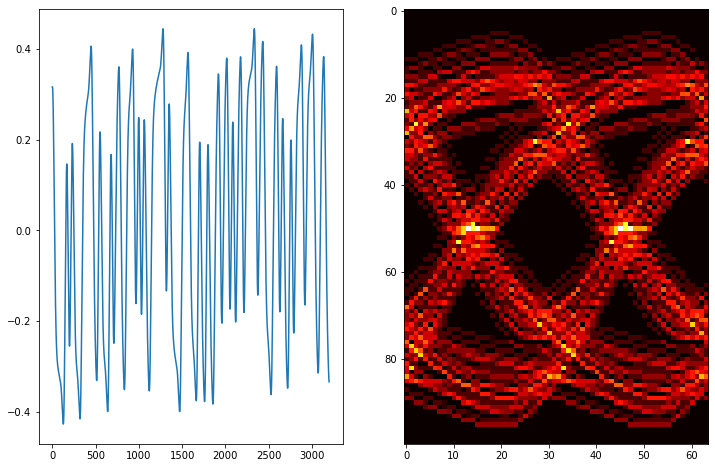

In [11]:
plotsig(myPyBERT.ctle_out)


### Notes

1. We've been able to open our eye nicely, using Tx deemphasis.


## Rx CTLE

Here, we investigate the effectiveness of the Rx CTLE as an alternative to the Tx FFE.


In [12]:
# Turn off the Tx deemphasis.
myPyBERT.tx_use_ami = False

# Turn on the Rx CTLE.
myPyBERT.rx_use_ami = True
# myPyBERT.rx_use_getwave = True
myPyBERT._rx_cfg.set_param_val(["Model_Specific","ctle_mode"],      1)
myPyBERT._rx_cfg.set_param_val(["Model_Specific","ctle_bandwidth"], 12e9)
myPyBERT._rx_cfg.set_param_val(["Model_Specific","ctle_freq"],      5e9)
myPyBERT._rx_cfg.set_param_val(["Model_Specific","ctle_mag"],       6)

# Rerun the simulation and plot the results.
myPyBERT.console_log = ""
my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
print(myPyBERT.console_log)



[2022-01-03 07:45:09.132633]: PyBERT: Rx IBIS-AMI model initialization results:
Input parameters: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap5 0.0)(dfe_tap4 0.0)(dfe_vout 1.0)(ctle_mag 6)(dfe_gain 0.1)(debug (dump_adaptation_input False) (dump_dfe_adaptation False) (dbg_enable False))(ctle_dcgain 0.0))
Message: Input parameter string: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap5 0.0)(dfe_tap4 0.0)(dfe_vout 1.0)(ctle_mag 6)(dfe_gain 0.1)(debug (dump_adaptation_input False) (dump_dfe_adaptation False) (dbg_enable False))(ctle_dcgain 0.0))
Debugging parameters:
	enable: 0
	sig_tap: 0
	init_adapt_tap: 0
Initializing Rx...
ibisami example Rx model was configured successfully, as follows:
	CTLE: 6 dB boost at 5 GHz
	DFE: not present

Output parameters: (example_rx
)



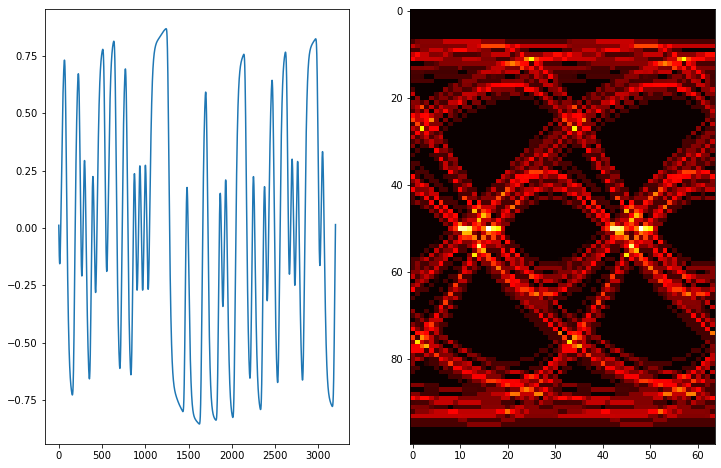

In [13]:
plotsig(myPyBERT.ctle_out)


### Notes

1. We've also been able to open our eye, using the Rx CTLE, although this results is a distinctly different shape to our eye.


## Combined Tx/Rx Equalization

Here, we investigate the effectiveness of using both the Tx Deemphasis and the Rx CTLE.


In [14]:
# Turn the Tx de-emphasis back on.
myPyBERT.tx_use_ami = True
myPyBERT.console_log = ""
my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
print(myPyBERT.console_log)



[2022-01-03 07:45:12.267772]: PyBERT: Tx IBIS-AMI model initialization results:
Input parameters: (example_tx (tx_tap_nm2 0)(tx_tap_np1 3)(tx_tap_units 27)(tx_tap_nm1 5))
Output parameters: (example_tx (tx_tap_units 27) (taps[0] 3) (taps[1] 19) (taps[2] 5) (taps[3] 0) (tap_weights_[0] -0.1221) (tap_weights_[1] 0.7733) (tap_weights_[2] -0.2035) (tap_weights_[3] -0)

Message: Initializing Tx...

[2022-01-03 07:45:12.335302]: PyBERT: Rx IBIS-AMI model initialization results:
Input parameters: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap5 0.0)(dfe_tap4 0.0)(dfe_vout 1.0)(ctle_mag 6)(dfe_gain 0.1)(debug (dump_adaptation_input False) (dump_dfe_adaptation False) (dbg_enable False))(ctle_dcgain 0.0))
Message: Input parameter string: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap

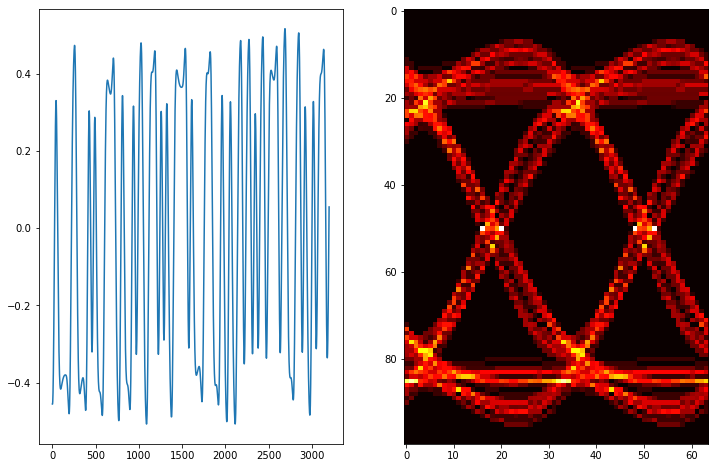

In [15]:
plotsig(myPyBERT.ctle_out)


### Notes

1. The combined usage of both Tx deemphasis and Rx CTLE has yielded a nicely open eye.


## DFE

Given the quality of the eye above, there's no real need for a DFE.
However, we'll try one here, for the sake of completeness.

In [16]:
myPyBERT.use_dfe    = True
# Tx FFE post-cursor taps are often redundant w/ DFE inclusion.
myPyBERT._tx_cfg.set_param_val(["Model_Specific","tx_tap_nm1"], 0)
myPyBERT.console_log = ""
my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
print(myPyBERT.console_log)



[2022-01-03 07:45:15.521717]: PyBERT: Tx IBIS-AMI model initialization results:
Input parameters: (example_tx (tx_tap_nm2 0)(tx_tap_np1 3)(tx_tap_units 27)(tx_tap_nm1 0))
Output parameters: (example_tx (tx_tap_units 27) (taps[0] 3) (taps[1] 24) (taps[2] 0) (taps[3] 0) (tap_weights_[0] -0.1221) (tap_weights_[1] 0.9768) (tap_weights_[2] -0) (tap_weights_[3] -0)

Message: Initializing Tx...

[2022-01-03 07:45:15.591349]: PyBERT: Rx IBIS-AMI model initialization results:
Input parameters: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap5 0.0)(dfe_tap4 0.0)(dfe_vout 1.0)(ctle_mag 6)(dfe_gain 0.1)(debug (dump_adaptation_input False) (dump_dfe_adaptation False) (dbg_enable False))(ctle_dcgain 0.0))
Message: Input parameter string: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap5 0.0

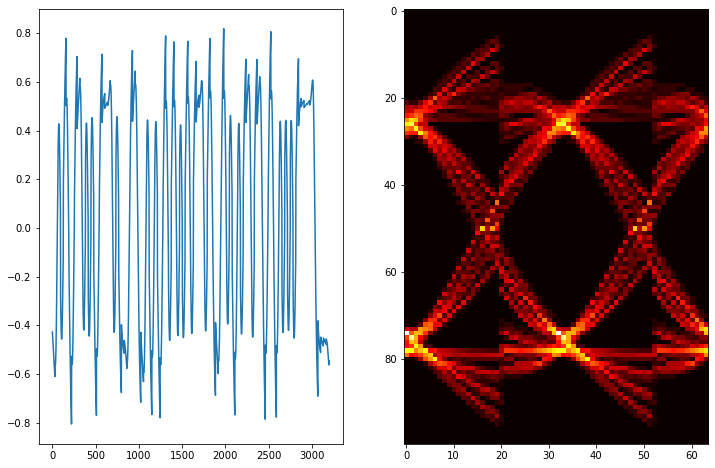

In [17]:
plotsig(myPyBERT.dfe_out)


### Notes

1. Eye quality is roughly equivalent to the _Combined Tx/Rx Equalization_ case.
And, since DFEs are often expensive and power hungry components, we elect to forgo a DFE for this link design.

1. The `DFE: not present` line in the output above may be confusing.
That line is coming from the IBIS-AMI model and we have that model's DFE deselected, in favor of using PyBERT's native DFE modeling, instead.

## Jitter Decomposition & Bathtub Curve Plotting

Here, we decompose the observed jitter into its different components and use that information to plot "bathtub" curves.
For this, we'll return to the pre-DFE simulation configuration.

In [18]:
myPyBERT.use_dfe    = False
myPyBERT._tx_cfg.set_param_val(["Model_Specific","tx_tap_nm1"], 5)
myPyBERT.console_log = ""
my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
print(myPyBERT.console_log)



[2022-01-03 07:45:18.638343]: PyBERT: Tx IBIS-AMI model initialization results:
Input parameters: (example_tx (tx_tap_nm2 0)(tx_tap_np1 3)(tx_tap_units 27)(tx_tap_nm1 5))
Output parameters: (example_tx (tx_tap_units 27) (taps[0] 3) (taps[1] 19) (taps[2] 5) (taps[3] 0) (tap_weights_[0] -0.1221) (tap_weights_[1] 0.7733) (tap_weights_[2] -0.2035) (tap_weights_[3] -0)

Message: Initializing Tx...

[2022-01-03 07:45:18.704545]: PyBERT: Rx IBIS-AMI model initialization results:
Input parameters: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap5 0.0)(dfe_tap4 0.0)(dfe_vout 1.0)(ctle_mag 6)(dfe_gain 0.1)(debug (dump_adaptation_input False) (dump_dfe_adaptation False) (dbg_enable False))(ctle_dcgain 0.0))
Message: Input parameter string: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap

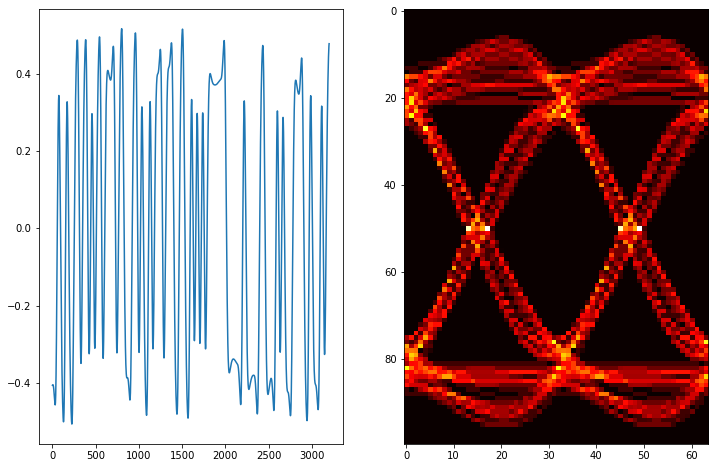

In [19]:
plotsig(myPyBERT.ctle_out)


Jitter (ps): ISI = 15.36, DCD =  0.04, PJ =  0.00, RJ =  0.01


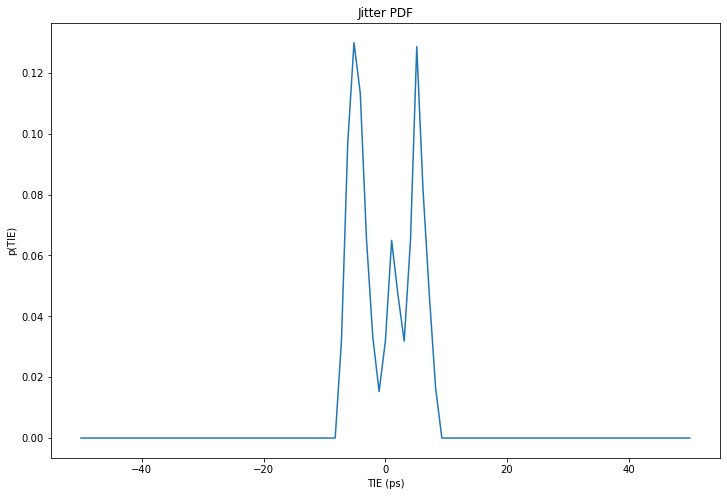

In [20]:
ideal_xings  = find_crossings(t, myPyBERT.tx_out)
actual_xings = find_crossings(t, myPyBERT.ctle_out)
(   jitter,
    t_jitter,
    isi,
    dcd,
    pj,
    rj,
    jitter_ext,
    thresh,
    jitter_spectrum,
    jitter_ind_spectrum,
    spectrum_freqs,
    hist,
    hist_synth,
    bin_centers,
) = calc_jitter(ui, eye_bits, myPyBERT.pattern_len, ideal_xings, actual_xings)
print(f"Jitter (ps): ISI = {isi*1e12:5.2f}, DCD = {dcd*1e12:5.2f}, PJ = {pj*1e12:5.2f}, RJ = {rj*1e12:5.2f}")
plt.plot(np.array(bin_centers) * 1e12, hist_synth)
plt.title("Jitter PDF")
plt.xlabel("TIE (ps)")
plt.ylabel("p(TIE)")
plt.show()

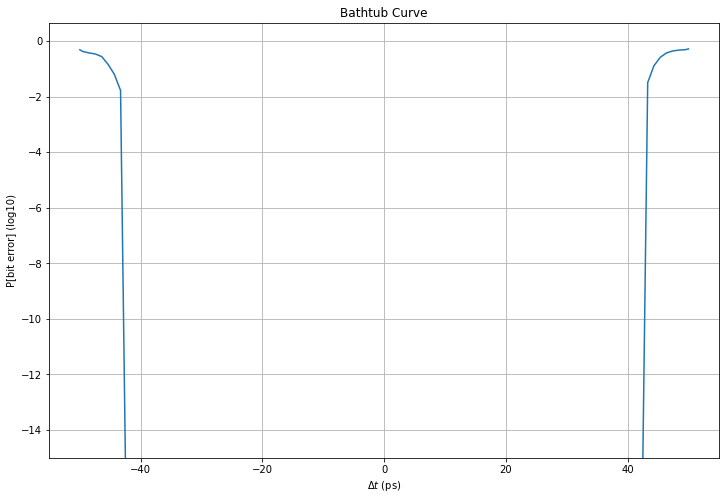

In [21]:
MIN_BATHTUB_VAL = 1.0e-18
half_len = len(hist_synth) // 2
bathtub = list(np.cumsum(hist_synth[-1 : -(half_len + 1) : -1]))
bathtub.reverse()
bathtub = np.array(bathtub + list(np.cumsum(hist_synth[: half_len + 1])))
bathtub = np.where(
    bathtub < MIN_BATHTUB_VAL, 0.1 * MIN_BATHTUB_VAL * np.ones(len(bathtub)), bathtub
)  # To avoid Chaco log scale plot wierdness.
plt.plot(np.array(bin_centers) * 1e12, np.log10(bathtub))
plt.title("Bathtub Curve")
plt.xlabel("$\Delta t$ (ps)")
plt.ylabel("P[bit error] (log10)")
plt.axis(ymin=-15)
plt.grid()
plt.show()

## Final Touches

The eye, jitter histogram, and bathtub curves above look great.
One might think we're done.
However, we've omitted two very important real World effects present in any serial communication link:

1. random noise

    Any real World link will have some amount of noise present that is completely independent of the data being sent. We typically model this sort of noise as being truly random, even though it really isn't.

1. CDR induced jitter

    When transmitting data serially, we don't transmit a separate clock.
Instead, the receiver must "extract" the clock from the incoming data stream.
The circuity that does this clock extraction often injects its own additional jitter into the system, and this must also be modeled.

Let's add these final two finishing touches now...

### Random Noise

PyBERT has a parameter for setting the _standard deviation_ of the _random vertical noise_ that it will add to the Tx output signal: `rn`.
Let's set that parameter to some non-zero value and see how it changes what we observe...

In [22]:
myPyBERT.rn = 0.5  # std. dev. of random noise (V)
myPyBERT.console_log = ""
my_run_simulation(myPyBERT, initial_run=False, update_plots=False)
print(myPyBERT.console_log)



[2022-01-03 07:45:22.190308]: PyBERT: Tx IBIS-AMI model initialization results:
Input parameters: (example_tx (tx_tap_nm2 0)(tx_tap_np1 3)(tx_tap_units 27)(tx_tap_nm1 5))
Output parameters: (example_tx (tx_tap_units 27) (taps[0] 3) (taps[1] 19) (taps[2] 5) (taps[3] 0) (tap_weights_[0] -0.1221) (tap_weights_[1] 0.7733) (tap_weights_[2] -0.2035) (tap_weights_[3] -0)

Message: Initializing Tx...

[2022-01-03 07:45:22.255092]: PyBERT: Rx IBIS-AMI model initialization results:
Input parameters: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap5 0.0)(dfe_tap4 0.0)(dfe_vout 1.0)(ctle_mag 6)(dfe_gain 0.1)(debug (dump_adaptation_input False) (dump_dfe_adaptation False) (dbg_enable False))(ctle_dcgain 0.0))
Message: Input parameter string: (example_rx (ctle_mode 1)(ctle_bandwidth 12000000000.0)(ctle_freq 5000000000.0)(dfe_mode 0)(dfe_tap3 0.0)(dfe_tap2 0.0)(dfe_tap1 0.0)(dfe_ntaps 5)(dfe_tap

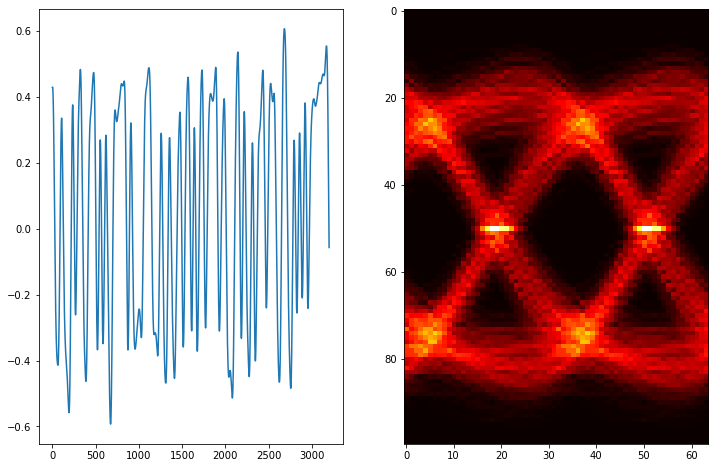

In [23]:
plotsig(myPyBERT.dfe_out)


Note how the eye now looks much more like something we'd actually observe on a scope in the lab.

Let's see how the jitter distribution has been affected...

Jitter (ps): ISI = 17.57, DCD =  0.32, PJ =  0.00, RJ =  1.30


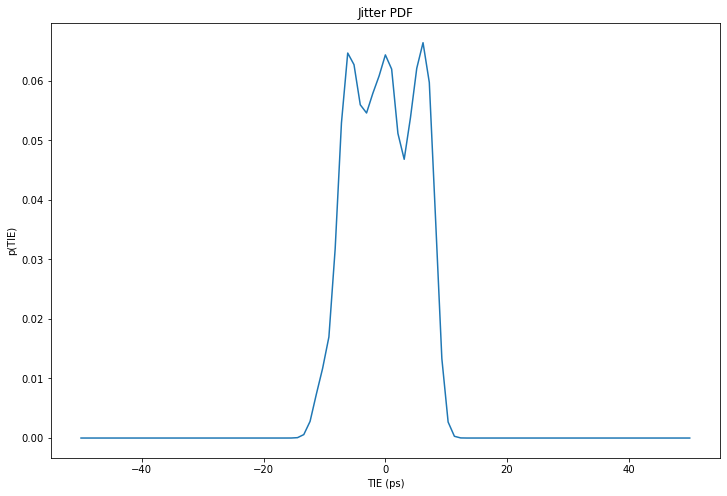

In [24]:
ideal_xings  = myPyBERT.ideal_xings
actual_xings = find_crossings(t, myPyBERT.ctle_out)
(   jitter,
    t_jitter,
    isi,
    dcd,
    pj,
    rj,
    jitter_ext,
    thresh,
    jitter_spectrum,
    jitter_ind_spectrum,
    spectrum_freqs,
    hist,
    hist_synth,
    bin_centers,
) = calc_jitter(ui, eye_bits, myPyBERT.pattern_len, ideal_xings, actual_xings)
print(f"Jitter (ps): ISI = {isi*1e12:5.2f}, DCD = {dcd*1e12:5.2f}, PJ = {pj*1e12:5.2f}, RJ = {rj*1e12:5.2f}")
plt.plot(np.array(bin_centers) * 1e12, hist_synth)
plt.title("Jitter PDF")
plt.xlabel("TIE (ps)")
plt.ylabel("p(TIE)")
plt.show()

Note how the jitter distribution now looks much more like a typical dual-Dirac distribution you may have seen displayed on a BERT scope.

Also, note the non-zero value being reported for `RJ`.  
(If you check above then you'll see that this value was previously being reported as zero.)  
**Question:** Why is this value _not_ equal to: `0.5`, the value we assigned to `rn`?

Finally, let's see how the bathtub curves have been affected by our addition of random noise...

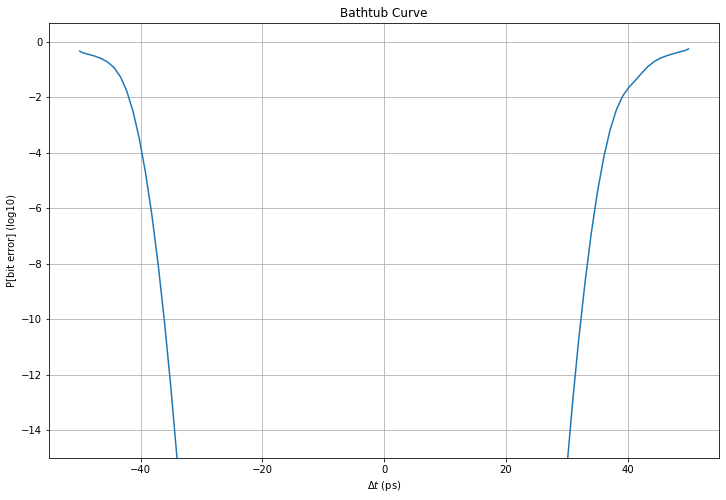

In [25]:
MIN_BATHTUB_VAL = 1.0e-18
half_len = len(hist_synth) // 2
bathtub = list(np.cumsum(hist_synth[-1 : -(half_len + 1) : -1]))
bathtub.reverse()
bathtub = np.array(bathtub + list(np.cumsum(hist_synth[: half_len + 1])))
bathtub = np.where(
    bathtub < MIN_BATHTUB_VAL, 0.1 * MIN_BATHTUB_VAL * np.ones(len(bathtub)), bathtub
)  # To avoid Chaco log scale plot wierdness.
plt.plot(np.array(bin_centers) * 1e12, np.log10(bathtub))
plt.title("Bathtub Curve")
plt.xlabel("$\Delta t$ (ps)")
plt.ylabel("P[bit error] (log10)")
plt.axis(ymin=-15)
plt.grid()
plt.show()

Note that the "walls" of the bathtub curves now have a shape we're more accustomed to seeing, having lost their vertical "cliffs"; this is directly due to the addition of random noise.

### CDR Induced Jitter

The circuitry that extracts the original clock signal from the incoming symbol stream is called the _clock from data recovery_ (CDR) circuit. And it introduces some jitter of its own, which we must include in our analysis.

Now, the exact relationship between this CDR induced jitter and that of the incoming symbol stream is quite complicated. And that makes a _correlated_ analysis beyond the scope of this simple treatment.
So, instead, we offer a simpler _uncorrelated_ analysis, asking the reader to take it on faith that this leads to a conservative estimation of BER.

An uncorrelated analysis of CDR induced jitter proceeds as follows:

1. Assemble a _time interval error_ (TIE) track for the sampling instants produced by the CDR, just as we do for the zero crossings of the incoming symbol stream.

1. Instead of decomposing the TIE, as we do for the incoming symbol stream crossings, just measure the _variance_ of this new TIE: $\sigma^2_{CDR}$.

1. Model the CDR induced jitter as a _Gaussian random process_ having variance: $\sigma^2_{CDR}$.

1. Repeat the jitter extrapolation and associated bathtub curve generation process, after _horizontally_ perturbing the crossing times of the incoming symbol stream with sampled values from our new "noise" generator.

    Note the difference, here, wrt/ previous applications of "random" noise:
    there, we were _vertically_ perturbing the samples of the incoming symbol stream.

Signal jitter std. dev. =  2.69 ps.
CDR    jitter std. dev. =  0.07 ps.
New    jitter std. dev. =  2.69 ps.
Jitter (ps): ISI = 17.78, DCD =  0.48, PJ =  0.00, RJ =  1.39


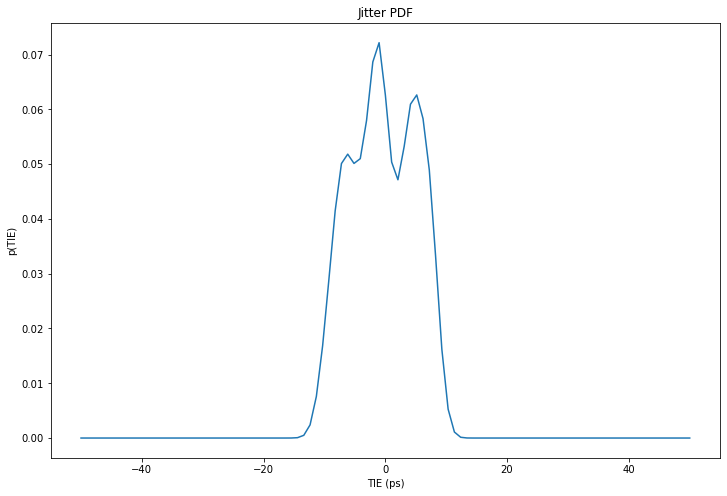

In [26]:
clk_times   = np.array(myPyBERT.clock_times)
valid_times = clk_times[np.where(clk_times > (t[-1] - ui*eye_bits))]
std_sig = myPyBERT.rj_dfe  # PyBERT's `rj_...` parameters hold std. dev.
var_sig = std_sig ** 2
var_cdr = np.var(np.diff(valid_times) - ui)
std_cdr = np.sqrt(var_cdr)
var_new = var_sig + var_cdr
std_new = np.sqrt(var_new)
print(f"Signal jitter std. dev. = {std_sig*1e12:5.2f} ps.")
print(f"CDR    jitter std. dev. = {std_cdr*1e12:5.2f} ps.")
print(f"New    jitter std. dev. = {std_new*1e12:5.2f} ps.")
new_xings = actual_xings + sp.stats.norm(scale=std_new).rvs(size=len(actual_xings))
(   jitter,
    t_jitter,
    isi,
    dcd,
    pj,
    rj,
    jitter_ext,
    thresh,
    jitter_spectrum,
    jitter_ind_spectrum,
    spectrum_freqs,
    hist,
    hist_synth,
    bin_centers,
) = calc_jitter(ui, eye_bits, myPyBERT.pattern_len, ideal_xings, new_xings)
print(f"Jitter (ps): ISI = {isi*1e12:5.2f}, DCD = {dcd*1e12:5.2f}, PJ = {pj*1e12:5.2f}, RJ = {rj*1e12:5.2f}")
plt.plot(np.array(bin_centers) * 1e12, hist_synth)
plt.title("Jitter PDF")
plt.xlabel("TIE (ps)")
plt.ylabel("p(TIE)")
plt.show()

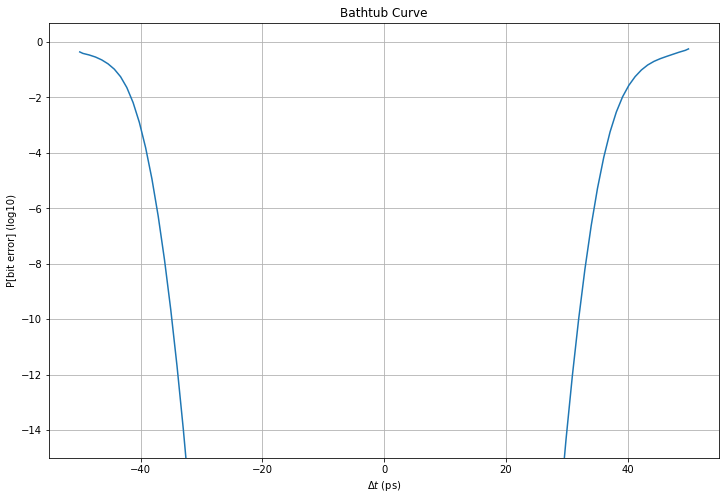

In [27]:
MIN_BATHTUB_VAL = 1.0e-18
half_len = len(hist_synth) // 2
bathtub = list(np.cumsum(hist_synth[-1 : -(half_len + 1) : -1]))
bathtub.reverse()
bathtub = np.array(bathtub + list(np.cumsum(hist_synth[: half_len + 1])))
bathtub = np.where(
    bathtub < MIN_BATHTUB_VAL, 0.1 * MIN_BATHTUB_VAL * np.ones(len(bathtub)), bathtub
)  # To avoid Chaco log scale plot wierdness.
plt.plot(np.array(bin_centers) * 1e12, np.log10(bathtub))
plt.title("Bathtub Curve")
plt.xlabel("$\Delta t$ (ps)")
plt.ylabel("P[bit error] (log10)")
plt.axis(ymin=-15)
plt.grid()
plt.show()

Note that in this case the CDR is _not_ contributing any appreciable extra jitter to the system.
That's because its inherent "flywheel" action is sufficiently momentous to filter out the jitter in the incoming symbol stream and provide a rock steady "heart beat" for signal sampling.